<a href="https://colab.research.google.com/github/elijahmflomo/Sem_2_ADVANCED-REINFORCEMENT-LEARNING/blob/main/ARL_LAB_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to model a warehouse environment as a **Markov Decision Process (MDP)** where a robot learns to deliver packages while avoiding obstacles.

### 1. Mathematical Modeling (The MDP)

To make this practical, we define the environment as follows:

* **States ():** A set of  coordinates representing the robot's position in a  grid.
* **Actions ():** `Up (0)`, `Down (1)`, `Left (2)`, `Right (3)`.
* **Rewards ():** * **+10** for reaching the Delivery Zone (Terminal State).
* **-5** for hitting an obstacle (Terminal State/Penalty).
* **-1** for every step taken (to encourage the shortest path).


* **Transitions ():** Deterministic movement (e.g., "Up" always moves the robot up one row unless it hits a wall).





### 2. Practical Implementation (Python)

We will use `numpy` for the backend logic and `matplotlib` for the "practical" visualization.

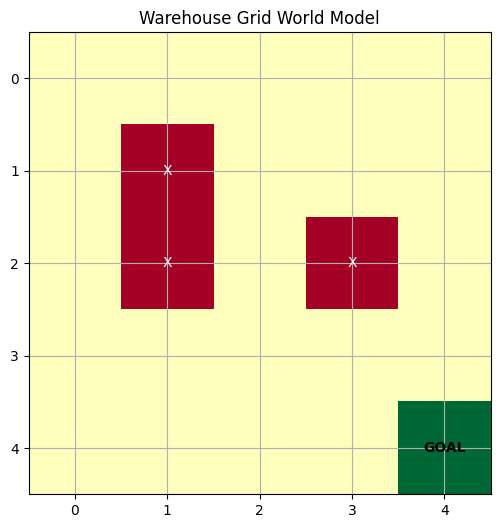

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class WarehouseMDP:
    def __init__(self, width=5, height=5):
        self.width = width
        self.height = height
        self.state_space = (height, width)
        self.action_space = [0, 1, 2, 3] # Up, Down, Left, Right

        # Define Special Zones
        self.delivery_zone = (4, 4)
        self.obstacles = [(1, 1), (2, 1), (2, 3)]

        # Initialize Rewards Table
        self.rewards = np.full(self.state_space, -1) # Movement penalty
        for obs in self.obstacles:
            self.rewards[obs] = -5 # Obstacle penalty
        self.rewards[self.delivery_zone] = 10 # Goal reward

    def is_terminal(self, state):
        return state == self.delivery_zone or state in self.obstacles

    def get_next_state(self, state, action):
        r, c = state
        if action == 0: # Up
            next_state = (max(r - 1, 0), c)
        elif action == 1: # Down
            next_state = (min(r + 1, self.height - 1), c)
        elif action == 2: # Left
            next_state = (r, max(c - 1, 0))
        elif action == 3: # Right
            next_state = (r, min(c + 1, self.width - 1))
        return next_state

    def visualize(self):
        grid = np.zeros(self.state_space)
        grid[self.delivery_zone] = 0.5 # Delivery
        for obs in self.obstacles:
            grid[obs] = -0.5 # Obstacles

        plt.figure(figsize=(6, 6))
        plt.imshow(grid, cmap='RdYlGn')
        plt.title("Warehouse Grid World Model")
        plt.grid(True)
        # Adding labels for clarity
        plt.text(4, 4, 'GOAL', ha='center', va='center', fontweight='bold')
        for obs in self.obstacles:
            plt.text(obs[1], obs[0], 'X', ha='center', va='center', color='white')
        plt.show()

# Initialize and Visualize
warehouse = WarehouseMDP()
warehouse.visualize()

## Assignment 2 (Lab 1): Shortest Path Planning for a Delivery Drone

In this assignment, we transition from just modeling the environment to solving it. We will use **Value Iteration**, a foundational Dynamic Programming algorithm, to compute the optimal path for a delivery drone.

### 1. The Strategy: Value Iteration

Value Iteration works by iteratively updating the "Value" () of each state based on the **Bellman Optimality Equation**. We calculate how much "future reward" a drone can expect from a specific position until the values converge.

*
**Energy Cost ():** We will set a movement penalty of **-2** (representing battery drain) and a destination reward of **+20**.


* **Discount Factor ():** We'll use **0.9** to make the drone prioritize reaching the goal sooner rather than later.

---

### 2. Practical Implementation

We will implement the solver and a visualization that shows the **Value Map** (how "good" each spot is) and the **Optimal Policy** (the arrows the drone should follow).


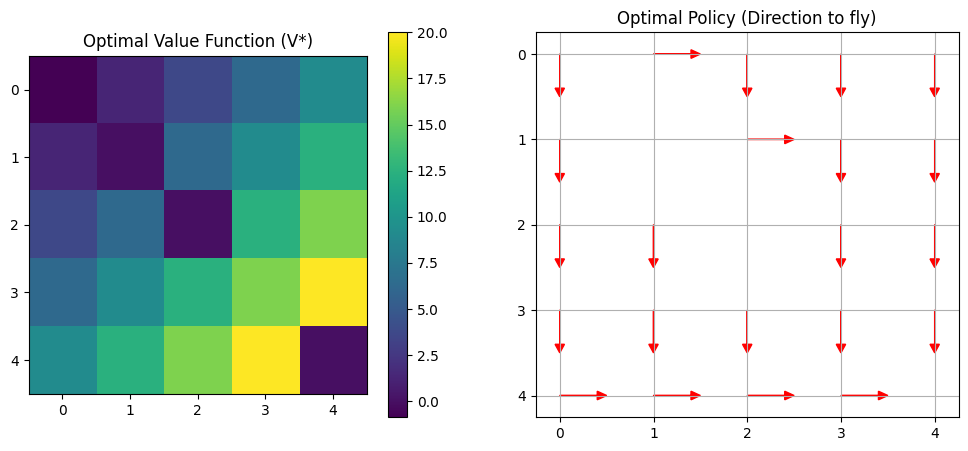

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class WarehouseMDP:
    def __init__(self, height=5, width=5):
        self.height = height
        self.width = width
        self.state_space = (height, width) # A tuple (rows, cols)
        # Actions: 0: Up, 1: Down, 2: Left, 3: Right
        self.action_space = [0, 1, 2, 3]

        # Initialize rewards grid, e.g., -1 for movement, 0 for terminal states initially
        self.rewards = -1 * np.ones((height, width))

        # Define delivery zone and obstacles
        self.delivery_zone = (height - 1, width - 1) # Example: bottom-right corner
        self.obstacles = [(1, 1), (2, 2)] # Example obstacles

        # Set rewards for delivery zone, will be overwritten by the user's code
        self.rewards[self.delivery_zone] = 0

    def is_terminal(self, state):
        return state == self.delivery_zone or state in self.obstacles

    def get_next_state(self, state, action):
        r, c = state
        original_r, original_c = r, c

        if action == 0: # Up
            r = max(0, r - 1)
        elif action == 1: # Down
            r = min(self.height - 1, r + 1)
        elif action == 2: # Left
            c = max(0, c - 1)
        elif action == 3: # Right
            c = min(self.width - 1, c + 1)

        next_state = (r, c)
        # If next state is an obstacle, stay in current state (no movement)
        if next_state in self.obstacles:
            return original_r, original_c # Return to the original state

        return next_state

class DroneValueIteration:
    def __init__(self, mdp, gamma=0.9, theta=1e-4):
        self.mdp = mdp
        self.gamma = gamma
        self.theta = theta # Convergence threshold
        self.V = np.zeros(mdp.state_space)
        self.policy = np.zeros(mdp.state_space, dtype=int)

    def solve(self):
        # 1. Value Iteration
        while True:
            delta = 0
            for r in range(self.mdp.height):
                for c in range(self.mdp.width):
                    state = (r, c)
                    if self.mdp.is_terminal(state):
                        continue

                    old_v = self.V[state]
                    action_values = []
                    for action in self.mdp.action_space:
                        next_s = self.mdp.get_next_state(state, action)
                        # Reward is -2 for movement, +20 for goal (handled by mdp.rewards)
                        reward = self.mdp.rewards[next_s]
                        action_values.append(reward + self.gamma * self.V[next_s])

                    self.V[state] = max(action_values)
                    delta = max(delta, abs(old_v - self.V[state]))

            if delta < self.theta:
                break

        # 2. Extract Optimal Policy
        for r in range(self.mdp.height):
            for c in range(self.mdp.width):
                state = (r, c)
                if self.mdp.is_terminal(state):
                    continue

                best_action = None
                best_value = -float('inf')
                for action in self.mdp.action_space:
                    next_s = self.mdp.get_next_state(state, action)
                    val = self.mdp.rewards[next_s] + self.gamma * self.V[next_s]
                    if val > best_value:
                        best_value = val
                        best_action = action
                self.policy[state] = best_action

    def visualize_results(self):
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Heatmap of Value Function
        im1 = ax[0].imshow(self.V, cmap='viridis')
        ax[0].set_title("Optimal Value Function (V*)")
        fig.colorbar(im1, ax=ax[0])

        # Policy Visualization (Arrows)
        ax[1].set_title("Optimal Policy (Direction to fly)")
        # Mapping action integers to arrow directions
        u_map = {0: -0.4, 1: 0.4, 2: 0, 3: 0} # Row movement
        v_map = {0: 0, 1: 0, 2: -0.4, 3: 0.4} # Col movement

        for r in range(self.mdp.height):
            for c in range(self.mdp.width):
                if self.mdp.is_terminal((r, c)):
                    continue
                act = self.policy[r, c]
                ax[1].arrow(c, r, v_map[act], u_map[act], head_width=0.1, head_length=0.1, fc='red', ec='red')

        ax[1].set_xticks(np.arange(self.mdp.width))
        ax[1].set_yticks(np.arange(self.mdp.height))
        ax[1].invert_yaxis()
        ax[1].grid(True)
        plt.show()

# Setup Drone MDP (reusing logic from assignment 1 but changing rewards)
drone_env = WarehouseMDP()
drone_env.rewards[drone_env.delivery_zone] = 20 # High reward for delivery
drone_env.rewards[np.where(drone_env.rewards == -1)] = -2 # Higher energy cost

# Solve and Visualize
solver = DroneValueIteration(drone_env)
solver.solve()
solver.visualize_results()

## Assignment 3 (Lab 1): Traffic Signal Control at an Intersection

In this assignment, we use **Policy Iteration** to optimize traffic signal timings. Unlike Value Iteration, which focuses on updating state values, Policy Iteration focuses on directly refining the agent's strategy.

### 1. The Strategy: Policy Iteration

Policy Iteration alternates between two main phases until the policy stabilizes:

1. **Policy Evaluation:** Calculate the exact value  of the current policy by solving linear equations or iteratively updating until convergence.
2. **Policy Improvement:** Update the policy to be "greedy" based on the new values, choosing actions that yield the highest expected return.

**Comparison Table: Value Iteration vs. Policy Iteration**

| Feature | Value Iteration | Policy Iteration |
| --- | --- | --- |
| **Starting Point** | Random value function | Random initial policy |
| **Complexity** | Simpler to implement | More complex (two phases) |
| **Convergence** | Slower (more iterations) | Faster (fewer total iterations) |
| **Intermediate Step** | Does not maintain a policy | Maintains an explicit policy throughout |

---

### 2. Practical Implementation

We will model a simplified intersection where the state is defined by the number of cars waiting in two directions: **North-South (NS)** and **East-West (EW)**.



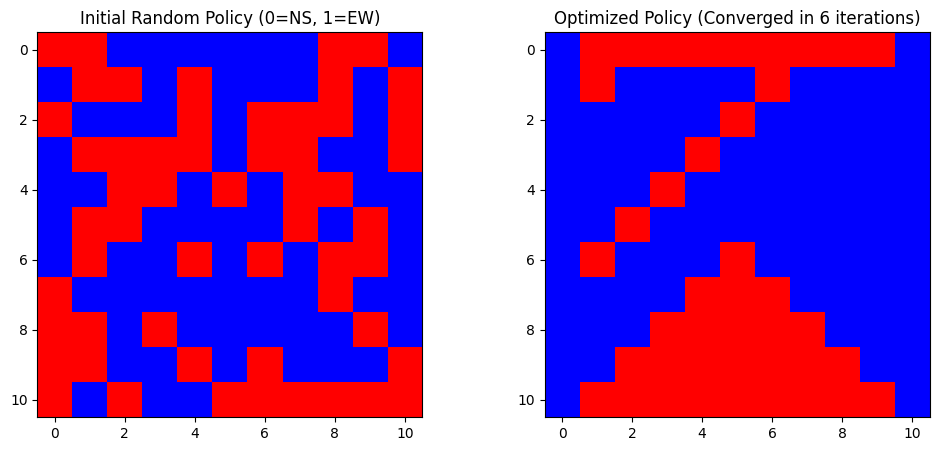

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class TrafficSignalMDP:
    def __init__(self, max_cars=10):
        self.max_cars = max_cars
        self.state_space = (max_cars + 1, max_cars + 1) # (cars_NS, cars_EW)
        self.actions = [0, 1] # 0: NS Green, 1: EW Green

        # Precompute transition dynamics (simplified)
        self.gamma = 0.9
        self.theta = 1e-3

    def get_reward(self, state):
        # Penalty is the sum of waiting vehicles (queue length)
        return -(state[0] + state[1])

    def get_transitions(self, state, action):
        ns, ew = state
        # Simulate traffic flow: 2 cars leave in green direction, 1 new car arrives everywhere
        if action == 0: # NS Green
            next_ns = max(0, min(self.max_cars, ns - 2 + 1))
            next_ew = min(self.max_cars, ew + 1)
        else: # EW Green
            next_ns = min(self.max_cars, ns + 1)
            next_ew = max(0, min(self.max_cars, ew - 2 + 1))
        return (next_ns, next_ew)

class PolicyIterationSolver:
    def __init__(self, mdp):
        self.mdp = mdp
        self.V = np.zeros(mdp.state_space)
        self.policy = np.random.choice(mdp.actions, size=mdp.state_space) # Random Policy

    def evaluate_policy(self):
        while True:
            delta = 0
            for r in range(self.mdp.max_cars + 1):
                for c in range(self.mdp.max_cars + 1):
                    s = (r, c)
                    old_v = self.V[s]
                    next_s = self.mdp.get_transitions(s, self.policy[s])
                    self.V[s] = self.mdp.get_reward(s) + self.mdp.gamma * self.V[next_s]
                    delta = max(delta, abs(old_v - self.V[s]))
            if delta < self.mdp.theta:
                break

    def improve_policy(self):
        policy_stable = True
        for r in range(self.mdp.max_cars + 1):
            for c in range(self.mdp.max_cars + 1):
                s = (r, c)
                old_action = self.policy[s]

                action_values = []
                for a in self.mdp.actions:
                    next_s = self.mdp.get_transitions(s, a)
                    action_values.append(self.mdp.get_reward(s) + self.mdp.gamma * self.V[next_s])

                self.policy[s] = np.argmax(action_values)
                if old_action != self.policy[s]:
                    policy_stable = False
        return policy_stable

    def solve(self):
        iterations = 0
        while True:
            self.evaluate_policy()
            stable = self.improve_policy()
            iterations += 1
            if stable: break
        return iterations

# Run Solver
mdp = TrafficSignalMDP()
solver = PolicyIterationSolver(mdp)
initial_policy = solver.policy.copy()
total_iterations = solver.solve()

# Comparison Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(initial_policy, cmap='bwr')
ax[0].set_title("Initial Random Policy (0=NS, 1=EW)")
ax[1].imshow(solver.policy, cmap='bwr')
ax[1].set_title(f"Optimized Policy (Converged in {total_iterations} iterations)")
plt.show()

## Assignment 4 (Lab 1): Rescue Robot in a Disaster Zone

For this final assignment, we will explore the **Discount Factor ()**, which is one of the most critical hyperparameters in Reinforcement Learning. It determines the agent's "horizon" or how much it cares about future rewards versus immediate ones.

### 1. The Strategy: Understanding Gamma ()

The discount factor ranges from  to :

* **Low  (e.g., 0.1):** The agent is "myopic" (short-sighted). It prioritizes immediate rewards and may ignore a huge reward that is just a few steps away.
* **High  (e.g., 0.99):** The agent is "farsighted." It is willing to endure many small penalties now to reach a massive reward in the future.

**Scenario Details:**

* **Victim (Goal):** +100 reward.
* **Unsafe Zones (Fire/Debris):** -50 penalty.
* **Movement:** -1 penalty (standard battery drain).

---

### 2. Practical Implementation

We will run the **Value Iteration** solver multiple times with different  values to see how the robot's behavior (the optimal policy) changes.


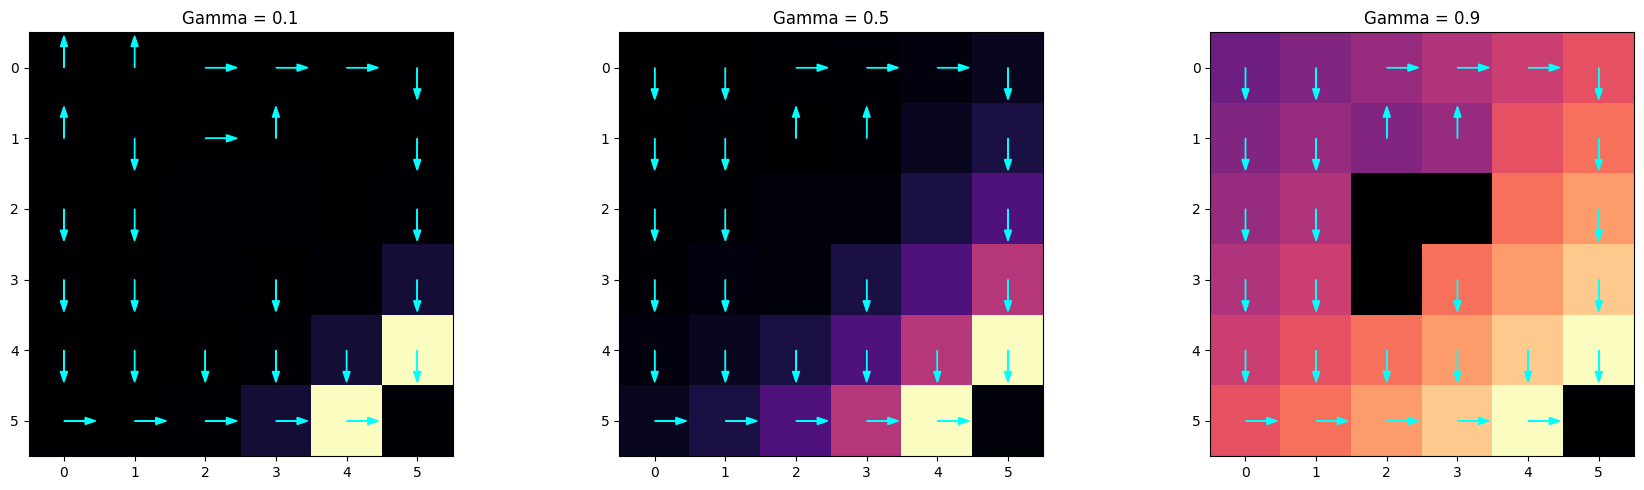

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class RescueRobotMDP(WarehouseMDP):
    def __init__(self):
        super().__init__(width=6, height=6)
        self.delivery_zone = (5, 5) # Victim location
        # Strategic obstacles creating a "dangerous but short" path vs "safe but long" path
        self.obstacles = [(2, 2), (2, 3), (3, 2)]
        self.unsafe_zones = [(1, 4), (2, 4), (3, 4)] # High penalty zones

        self.rewards = np.full(self.state_space, -1)
        self.rewards[self.delivery_zone] = 100
        for uz in self.unsafe_zones:
            self.rewards[uz] = -50

def run_experiment(gammas=[0.1, 0.5, 0.9]):
    fig, axes = plt.subplots(1, len(gammas), figsize=(18, 5))

    for i, g in enumerate(gammas):
        env = RescueRobotMDP()
        solver = DroneValueIteration(env, gamma=g)
        solver.solve()

        axes[i].imshow(solver.V, cmap='magma')
        axes[i].set_title(f"Gamma = {g}")

        # Draw Policy Arrows
        u_map, v_map = {0: -0.3, 1: 0.3, 2: 0, 3: 0}, {0: 0, 1: 0, 2: -0.3, 3: 0.3}
        for r in range(env.height):
            for c in range(env.width):
                if env.is_terminal((r, c)) or (r, c) in env.unsafe_zones:
                    continue
                act = solver.policy[r, c]
                axes[i].arrow(c, r, v_map[act], u_map[act], head_width=0.1, color='cyan')

    plt.tight_layout()
    plt.show()

run_experiment()

